# Data Cleaning Exercise

Cleaning your data is crucial when starting a new data engineering project because it ensures the accuracy, consistency, and reliability of the dataset. Dirty data, which may include duplicates, missing values, and errors, can lead to incorrect analysis and insights, ultimately affecting the decision-making process. Data cleaning helps in identifying and rectifying these issues, providing a solid foundation for building effective data models and analytics. Additionally, clean data improves the performance of algorithms and enhances the overall efficiency of the project, leading to more trustworthy and actionable results.

Use Python, ```numpy```, ```pandas``` and/or ```matplotlib``` to analyse and clean your batch data:

## Import Libraries

In [3]:
# TODO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

## Load Data

Link to data source: ```<TODO>```

In [22]:
# TODO
file_path = r'../Job Posting.csv/Job Posting.csv'
try:
    rawdata = pd.read_csv(file_path, encoding='latin1')
    print("Data successfully loaded.")
except FileNotFoundError:
    print(f"Data not found: {file_path}")
except Exception as e:
    print(f"Error at loading the data: {e}")

Data successfully loaded.


## Understand the Data

View the first few rows, get summary statistics and check data types

In [23]:
# TODO
rawdata.head()

rawdata.describe(include='all').transpose()

summary = pd.DataFrame({
    'datatype':         rawdata.dtypes,
    'non_null_count':   rawdata.count(),
    'missing_count':    rawdata.isnull().sum(),
    'missing_percent':  (rawdata.isnull().mean() * 100).round(1)
})
summary

,datatype,non_null_count,missing_count,missing_percent
Website Domain,object,9919,0,0.0
Ticker,float64,0,9919,100.0
Job Opening Title,object,9919,0,0.0
Job Opening URL,object,9919,0,0.0
First Seen At,object,9919,0,0.0
Last Seen At,object,9919,0,0.0
Location,object,9508,411,4.1
Location Data,object,9919,0,0.0
Category,object,8250,1669,16.8
Seniority,object,9919,0,0.0


## Handle Missing Data

Identify missing values and fill or drop missing values

In [24]:
# TODO
# 1) Überblick vor dem Reinigen
print("Shape before cleaning:", rawdata.shape)
print("\nMissing values before cleaning:\n", rawdata.isnull().sum())

# wir legen eine neue Variable an, damit rawdata erhalten bleibt
data = rawdata.copy()

# 2) Spalten mit zu vielen Nulls (> 80 %) droppen
threshold = 0.8
high_null_columns = data.columns[data.isnull().mean() > threshold].tolist()
print(f"\nSpalten mit mehr als {int(threshold * 100)} % Nulls, die gedroppt werden:", high_null_columns)
data = data.drop(columns=high_null_columns)

# 3) Numerische Spalten mit Median füllen
number_columns = data.select_dtypes(include='number').columns
medians = data[number_columns].median()
data[number_columns] = data[number_columns].fillna(medians)

# 4) String-Spalten mit 'Unknown' füllen
string_columns = data.select_dtypes(include=['object']).columns
for col in string_columns:
    data[col] = data[col].fillna('Unknown')

# 5) Kontrolle nach dem Reinigen
print("\nShape after cleaning:", data.shape)
print("\nMissing values after cleaning:\n", data.isnull().sum())


Shape before cleaning: (9919, 21)

Missing values before cleaning:
 Website Domain              0
Ticker                   9919
Job Opening Title           0
Job Opening URL             0
First Seen At               0
Last Seen At                0
Location                  411
Location Data               0
Category                 1669
Seniority                   0
Keywords                 2273
Description               112
Salary                   9343
Salary Data                 0
Contract Types           1915
Job Status               3147
Job Language                2
Job Last Processed At       0
O*NET Code                  3
O*NET Family                3
O*NET Occupation Name       3
dtype: int64

Spalten mit mehr als 80 % Nulls, die gedroppt werden: ['Ticker', 'Salary']

Shape after cleaning: (9919, 19)

Missing values after cleaning:
 Website Domain           0
Job Opening Title        0
Job Opening URL          0
First Seen At            0
Last Seen At             0
Location   

## Handle Duplicates

Identify duplicates and remove them

In [25]:
# TODO
print("Duplicates sum:", data.duplicated().sum())

Duplicates sum: 0


## Handle Outliers

Identify outliers and remove or corret them

In [26]:
# TODO
# Prüfen, ob numerische Spalten vorhanden sind
numeric_cols = data.select_dtypes(include='number').columns
if numeric_cols.empty:
    print("No numerical columns (int/float) available - outlier analysis not applicable.")
else:
    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        mask = (data[col] < Q1 - 1.5 * IQR) | (data[col] > Q3 + 1.5 * IQR)
        print(f"{col}: {mask.sum()} Ausreißer")



No numerical columns (int/float) available - outlier analysis not applicable.


## Handle Incorrect Data Types

In [27]:
# TODO

import re

# 1) Aktuelle Datentypen
print("Current datatypes:")
print(data.dtypes, "\n")

# 2) Für jede object-Spalte prüfen
total = len(data)
date_regex = re.compile(r'^\d{4}-\d{2}-\d{2}T')  # ISO-8601 Beginn: YYYY-MM-DDT

for col in data.select_dtypes(include='object').columns:
    # Prozent numeric
    num_pct = (pd.to_numeric(data[col], errors='coerce').notnull().mean() * 100).round(1)

    # Prozent, der mit dem RegEx als Datum erkannt wird
    date_pct = (data[col].astype(str)
                .str.match(date_regex)
                .mean() * 100).round(1)

    print(f"{col!r}: {num_pct}% numeric, {date_pct}% ISO-Date")

    # wenn >90% ISO-Date, tatsächlich umwandeln
    if date_pct > 90:
        data[col] = pd.to_datetime(data[col], errors='coerce')
        print(f"  → Converted {col!r} to datetime64[ns]")

# 3) Neue Typen ansehen
print("\nNew datatypes:")
print(data.dtypes)



Current datatypes:
Website Domain           object
Job Opening Title        object
Job Opening URL          object
First Seen At            object
Last Seen At             object
Location                 object
Location Data            object
Category                 object
Seniority                object
Keywords                 object
Description              object
Salary Data              object
Contract Types           object
Job Status               object
Job Language             object
Job Last Processed At    object
O*NET Code               object
O*NET Family             object
O*NET Occupation Name    object
dtype: object 

'Website Domain': 0.0% numeric, 0.0% ISO-Date
'Job Opening Title': 0.0% numeric, 0.0% ISO-Date
'Job Opening URL': 0.0% numeric, 0.0% ISO-Date
'First Seen At': 0.0% numeric, 100.0% ISO-Date
  → Converted 'First Seen At' to datetime64[ns]
'Last Seen At': 0.0% numeric, 100.0% ISO-Date
  → Converted 'Last Seen At' to datetime64[ns]
'Location': 0.0% numeric, 0

## Visualize Data

Use graphes, plots and/or diagrams to visualize the data

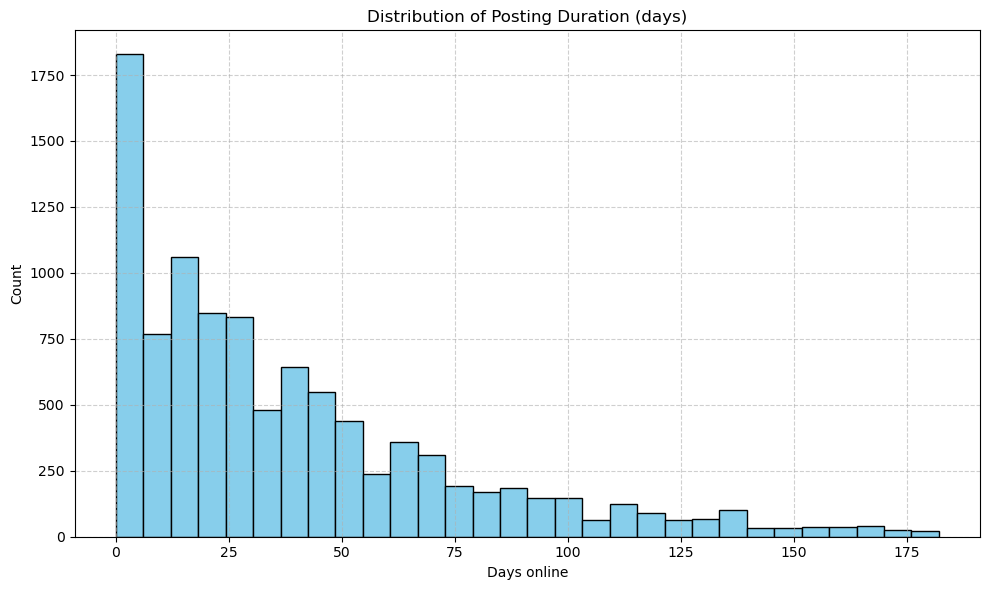

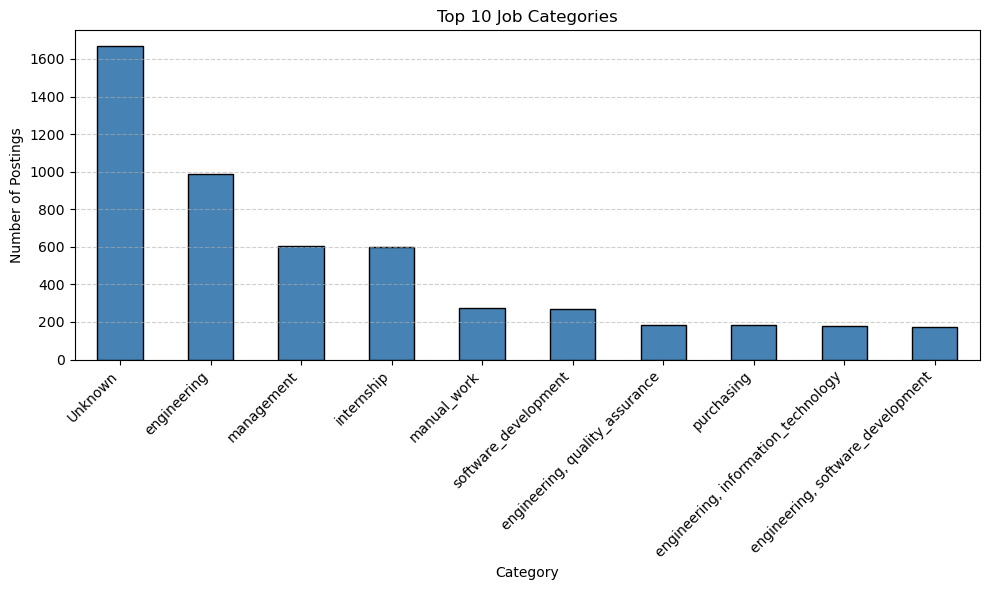

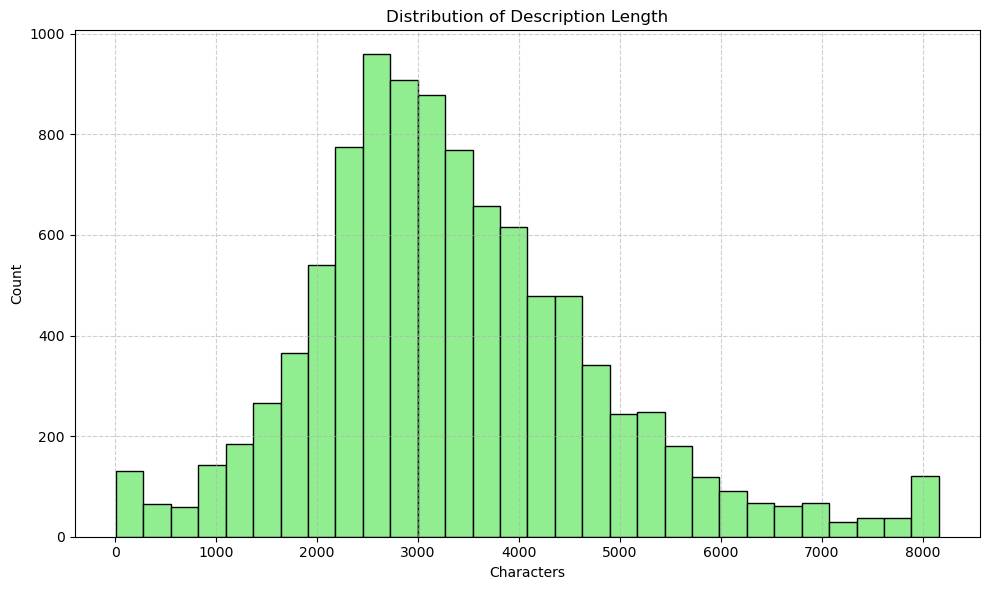

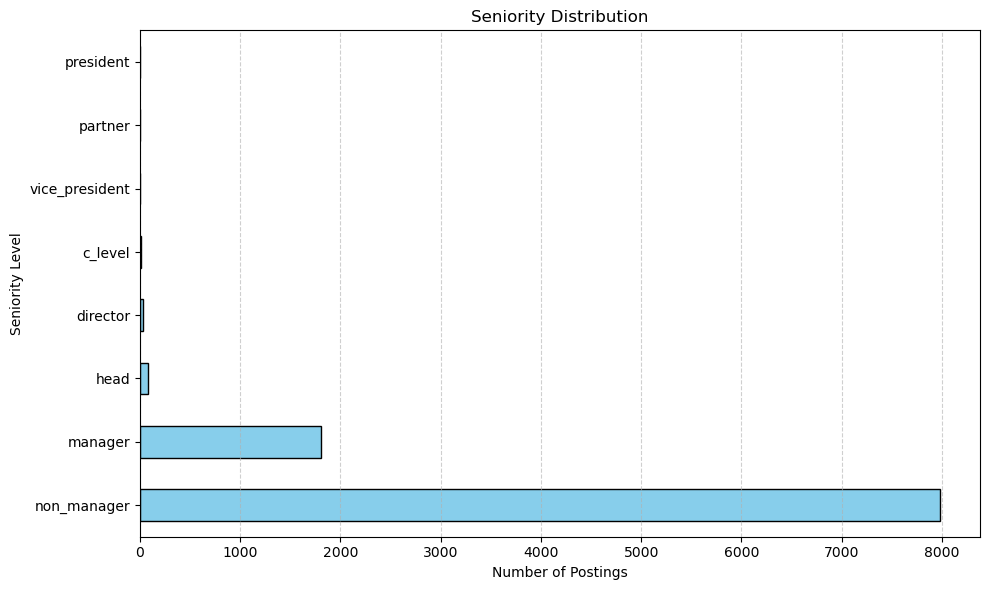

In [28]:
# TODO

# 1) Posting-Dauer in Tagen
data['duration_days'] = (data['Last Seen At'] - data['First Seen At']).dt.days
plot.figure(figsize=(10, 6))
plot.hist(data['duration_days'].dropna(), bins=30, color='skyblue', edgecolor='black')
plot.title('Distribution of Posting Duration (days)')
plot.xlabel('Days online')
plot.ylabel('Count')
plot.grid(True, linestyle='--', alpha=0.6)
plot.tight_layout()
plot.show()

# 2) Top 10 Job Kategorien
top_categories = data['Category'].value_counts().nlargest(10)
plot.figure(figsize=(10, 6))
top_categories.plot.bar(color='steelblue', edgecolor='black')
plot.title('Top 10 Job Categories')
plot.xlabel('Category')
plot.ylabel('Number of Postings')
plot.xticks(rotation=45, ha='right')
plot.grid(axis='y', linestyle='--', alpha=0.6)
plot.tight_layout()
plot.show()

# 3) Länge der Job-Beschreibung
data['desc_len'] = data['Description'].astype(str).str.len()
plot.figure(figsize=(10, 6))
plot.hist(data['desc_len'].dropna(), bins=30, color='lightgreen', edgecolor='black')
plot.title('Distribution of Description Length')
plot.xlabel('Characters')
plot.ylabel('Count')
plot.grid(True, linestyle='--', alpha=0.6)
plot.tight_layout()
plot.show()

# 4) Seniority-Verteilung
seniority_counts = data['Seniority'].value_counts()
plot.figure(figsize=(10, 6))
seniority_counts.plot.barh(color='skyblue', edgecolor='black')
plot.title('Seniority Distribution')
plot.xlabel('Number of Postings')
plot.ylabel('Seniority Level')
plot.grid(axis='x', linestyle='--', alpha=0.6)
plot.tight_layout()
plot.show()


## Save Cleaned Data

In [29]:
# TODO

output_path = '../Job Posting.csv/Job Posting_cleaned.csv'

data.to_csv(output_path, index=False)

print(f"Cleaned data saved to: {output_path}")


Cleaned data saved to: ../Job Posting.csv/Job Posting_cleaned.csv
